# Getting Started

In this tutorial, you'll learn the basics of using the `tuesday` package.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as un

%matplotlib inline

import powerbox as pb

from tuesday.core import calculate_ps, plot_power_spectrum

## Calculate the PS from a coeval box

Let's make a test coeval box using `powerbox`.

In [2]:
delta_x = pb.PowerBox(
    N=32,  # Number of grid-points in the box
    dim=3,  # 2D box
    pk=lambda k: 0.1 * k**-2.0,  # The power-spectrum
    boxlength=200.0,  # Size of the box (sets the units of k in pk)
    seed=1010,  # Set a seed to ensure the box looks the same every time (optional)
).delta_x()
delta_x_redshift = np.linspace(0, 200, delta_x.shape[-1])

Let's calculate the PS on this box:

In [3]:
ps = calculate_ps(
    delta_x * un.dimensionless_unscaled,
    delta_x_redshift,
    zs=100.0,
    box_length=200.0 * un.Mpc,
    calc_2d=True,
    calc_1d=True,
    prefactor_fnc=None,
)

/home/dani/miniconda3/envs/21cmFAST/lib/python3.11/site-packages/powerbox/tools.py:261: FutureWarning: In the future, bins will be generated by default up to the smallest length over any dimension, instead of the largest magnitude for the box.Set bins_upto_boxlen to silence this warning.
  bins = _getbins(bins, coord_mags, log_bins, bins_upto_boxlen=bins_upto_boxlen)
/home/dani/miniconda3/envs/21cmFAST/lib/python3.11/site-packages/powerbox/tools.py:287: RuntimeWarning: invalid value encountered in divide
  np.bincount(
/home/dani/miniconda3/envs/21cmFAST/lib/python3.11/site-packages/powerbox/tools.py:551: RuntimeWarning: invalid value encountered in divide
  np.bincount(
/home/dani/miniconda3/envs/21cmFAST/lib/python3.11/site-packages/powerbox/tools.py:732: UserWarning: One or more radial bins had no cells within it.
  return angular_average(


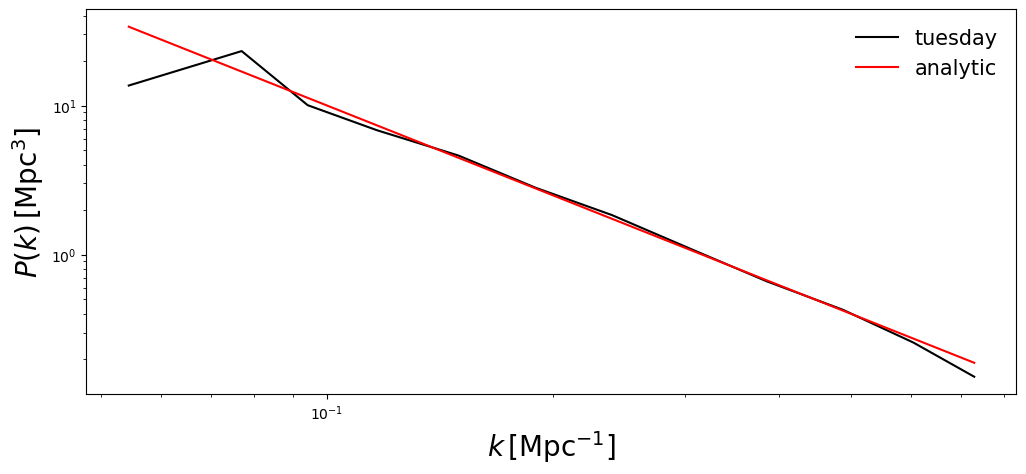

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
fig, ax = plot_power_spectrum(
    ps["k"],
    np.append(ps["ps_1D"].value, 0.1 * ps["k"][None, ...].value ** -2.0, axis=0)
    * ps["ps_1D"].unit,
    fontsize=20,
    fig=fig,
    colors=["k", "r"],
    labels=["tuesday", "analytic"],
    leg_kwargs={"loc": "upper right", "frameon": False, "fontsize": 15},
    log=True,
)

We can also plot the 2D power spectrum:

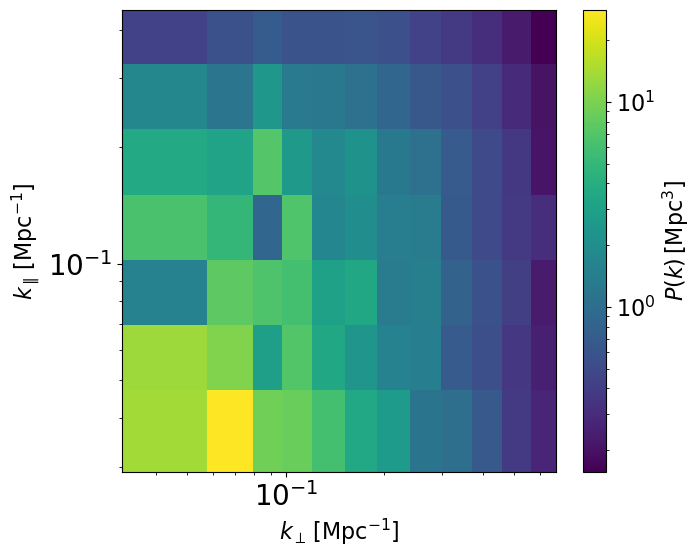

In [5]:
fig, ax = plot_power_spectrum(
    [ps["final_kperp"], ps["final_kpar"]],
    ps["final_ps_2D"][0],
    log=True,
)